# Import necessary libraries

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import xarray
import geopandas as gpd
from shapely.geometry import Point
from scipy.spatial import cKDTree

# Load the dataset

In [7]:

# anfel_path = r"C:\Users\anfel\OneDrive\Desktop\M2\prjt\data\algeria_tunisia.csv"
# dataset = pd.read_csv(anfel_path)

ramzi_path = r"../local_dataset/raw/fire/algeria_tunisia.csv"
dataset = pd.read_csv(ramzi_path)

print("Shape of the dataset:", dataset.shape)
print("data types of the dataset:")
print(dataset.dtypes)
print("\n"*2)

dataset.info()
print("\n"*2)

dataset.describe()
print("\n"*2)

print(dataset.head())



Shape of the dataset: (90250, 15)
data types of the dataset:
latitude      float64
longitude     float64
bright_ti4    float64
scan          float64
track         float64
acq_date       object
acq_time        int64
satellite      object
instrument     object
confidence     object
version         int64
bright_ti5    float64
frp           float64
daynight       object
type            int64
dtype: object



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90250 entries, 0 to 90249
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   latitude    90250 non-null  float64
 1   longitude   90250 non-null  float64
 2   bright_ti4  90250 non-null  float64
 3   scan        90250 non-null  float64
 4   track       90250 non-null  float64
 5   acq_date    90250 non-null  object 
 6   acq_time    90250 non-null  int64  
 7   satellite   90250 non-null  object 
 8   instrument  90250 non-null  object 
 9   confidence  90250 non-null 

### Attribut classe 

In [3]:
# Afficher toutes les valeurs uniques et leur fréquence (pour valider si ce sont bien des 1, 2, et 3)
print("Distribution des codes de feux ('type'):")
print(dataset['type'].value_counts())
print("\n")

Distribution des codes de feux ('type'):
type
2    75495
0    14216
3      539
Name: count, dtype: int64




# Draw map 

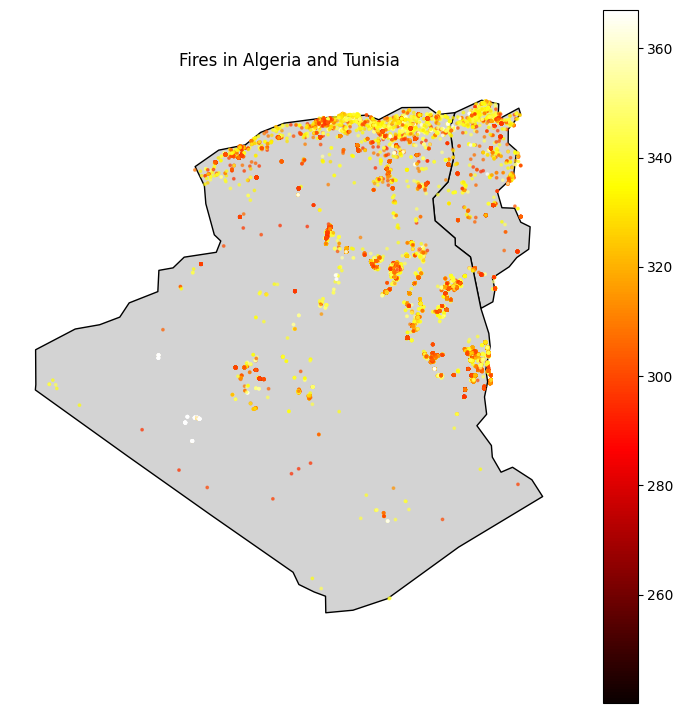

In [ ]:
# Load the shapefile (country boundaries)
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefile (country boundaries)
shp_path = r"../local_dataset/raw/world/ne_110m_admin_0_countries.shp"
world = gpd.read_file(shp_path)

# Select only Algeria and Tunisia
countries = world[world["ADMIN"].isin(["Algeria", "Tunisia"])]

# Convert countries to Web Mercator
countries = countries.to_crs(epsg=3857)

# Convert fires to GeoDataFrame and Web Mercator
fires = gpd.GeoDataFrame(dataset, 
                         geometry=gpd.points_from_xy(dataset.longitude, dataset.latitude),
                         crs='EPSG:4326')
fires = fires.to_crs(epsg=3857)

# Plot countries
ax = countries.plot(figsize=(9,9), color='lightgrey', edgecolor='black')

# Overlay fire points
fires.plot(ax=ax,
           column='bright_ti4',
           cmap='hot',
           markersize=3,
           alpha=0.6,
           legend=True)

ax.set_axis_off()
plt.title("Fires in Algeria and Tunisia")
plt.show()


# Remove useless features

In [14]:
dataset.drop(columns=["satellite", "instrument", "version", "scan", "track"], inplace=True)
dataset.rename(columns={"longitude": "lon", "latitude": "lat"}, inplace=True)
all_cols = dataset.drop(columns=["acq_date", "lon", "lat"])
print("Shape of the dataset after removing useless features:", all_cols.shape)

Shape of the dataset after removing useless features: (90250, 7)


# Feature analysis

=== Numeric columns ===
bright_ti4    float64
scan          float64
track         float64
acq_time        int64
bright_ti5    float64
frp           float64
type            int64
dtype: object
=== String columns ===
confidence    object
daynight      object
dtype: object


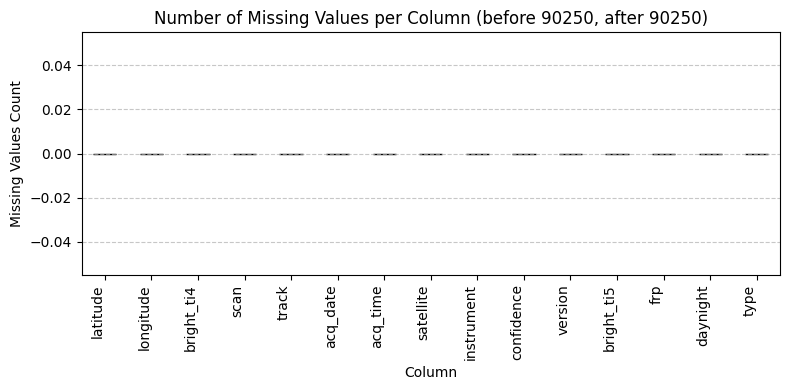

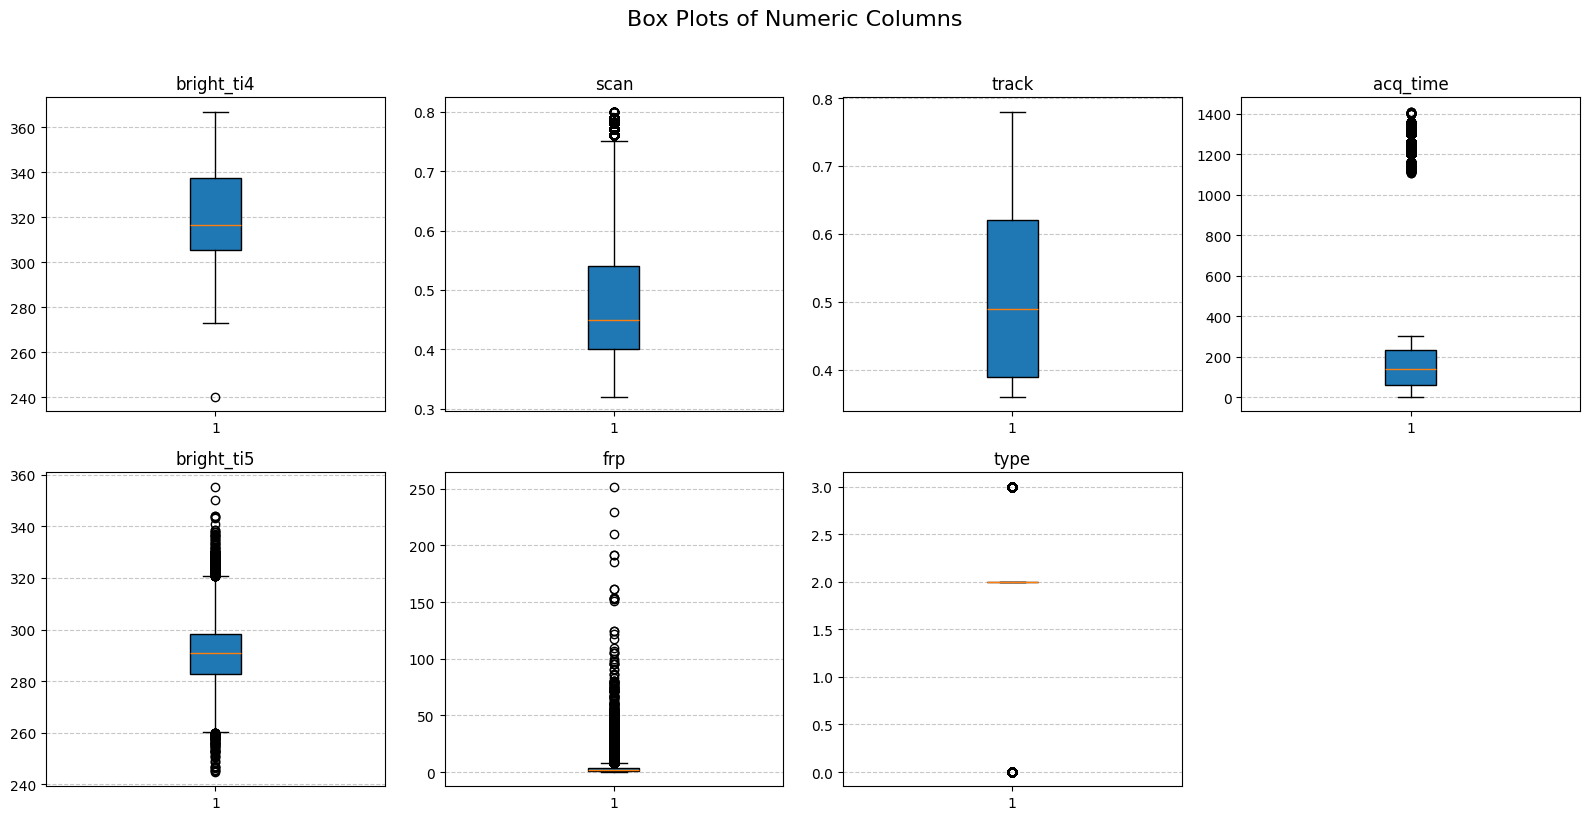

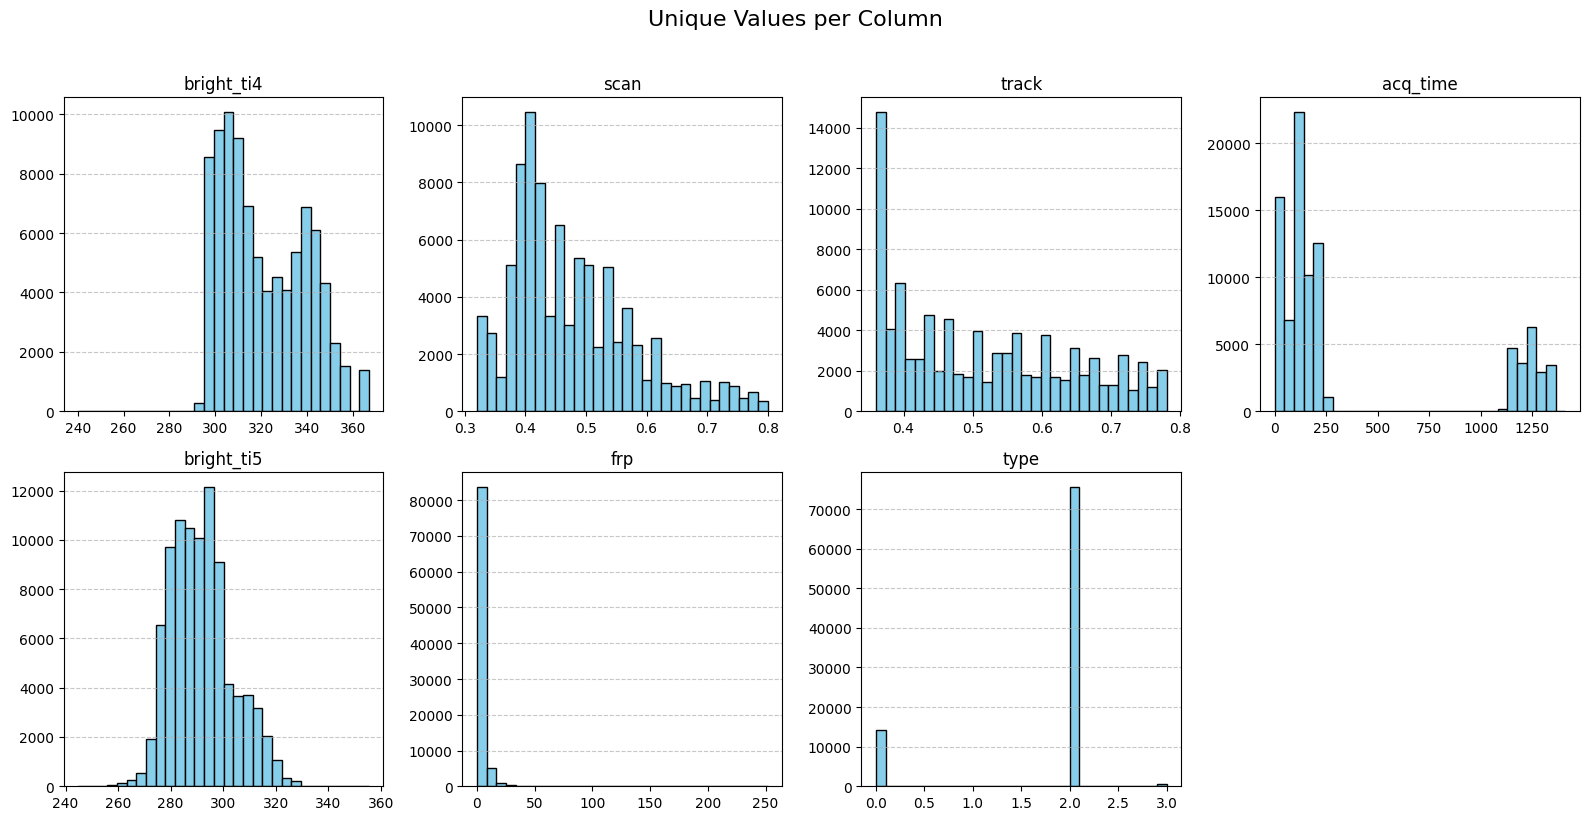

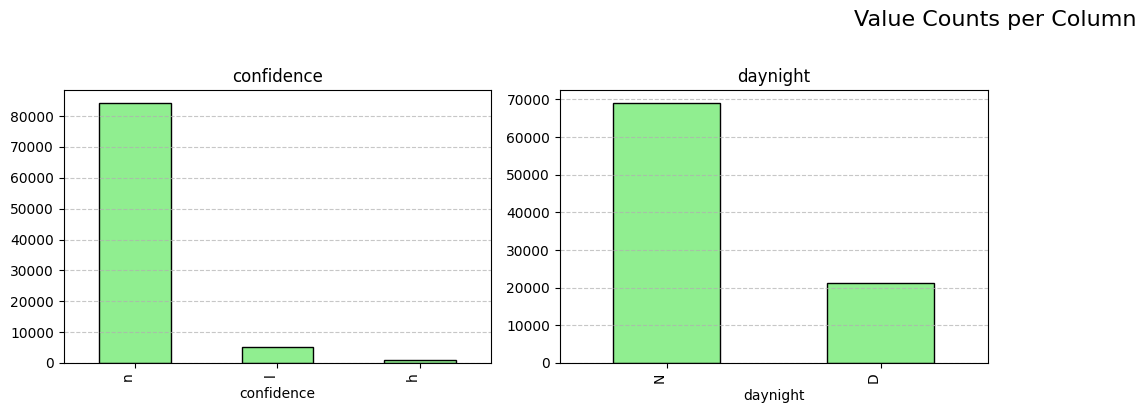

In [ ]:
def plot_missing_values(all_cols):
    missing_values_percentage = all_cols.isnull().sum()
    old_number_of_rows = all_cols.shape[0]
    plt.figure(figsize=(8,4))
    missing_values_percentage.plot(kind='bar', color='salmon', edgecolor='black')
    new_number_of_rows = all_cols.dropna().shape[0]

    plt.title(f"Number of Missing Values per Column (before {old_number_of_rows}, after {new_number_of_rows})")
    plt.ylabel("Missing Values Count")
    plt.xlabel("Column")
    plt.xticks(rotation=90, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

cols_per_row = 4  # you can change to 3 or 5 depending on your screen

def plot_box_plots(numeric_cols):
    n = len(numeric_cols.columns)
    rows = math.ceil(n / cols_per_row)
    plt.figure(figsize=(cols_per_row * 4, rows * 4))
    plt.suptitle("Box Plots of Numeric Columns", fontsize=16, y=1.02)
    for i, col in enumerate(numeric_cols.columns, 1):
        plt.subplot(rows, cols_per_row, i)
        plt.boxplot(numeric_cols[col], vert=True, patch_artist=True)
        plt.title(col)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

def plot_histograms(numeric_cols):
    n = len(numeric_cols.columns)
    rows = math.ceil(n / cols_per_row)
    plt.figure(figsize=(cols_per_row * 4, rows * 4))
    plt.suptitle("Unique Values per Column", fontsize=16, y=1.02)
    for i, col in enumerate(numeric_cols.columns, 1):
        plt.subplot(rows, cols_per_row, i)
        plt.hist(numeric_cols[col], bins=30, color='skyblue', edgecolor='black')
        plt.title(col)
        plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

def plot_bar_charts(nominal_cols):
    n = len(nominal_cols.columns)
    rows = math.ceil(n / cols_per_row)
    plt.figure(figsize=(cols_per_row * 5, rows * 4))
    plt.suptitle("Value Counts per Column", fontsize=16, y=1.02)
    
    for i, col in enumerate(nominal_cols.columns, 1):
        plt.subplot(rows, cols_per_row, i)
        value_counts = nominal_cols[col].value_counts()
        value_counts.plot(kind='bar', color='lightgreen', edgecolor='black')
        plt.title(col)
        plt.xticks(rotation=90, ha="right")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()



numeric_cols = all_cols.select_dtypes(include=["number"])
string_cols = all_cols.select_dtypes(include=["object"])

print("=== Numeric columns ===")
print(numeric_cols.dtypes)
print("=== String columns ===")
print(string_cols.dtypes)

plot_missing_values(dataset)
plot_box_plots(numeric_cols)
plot_histograms(numeric_cols)
plot_bar_charts(string_cols)



# Correlation matrix

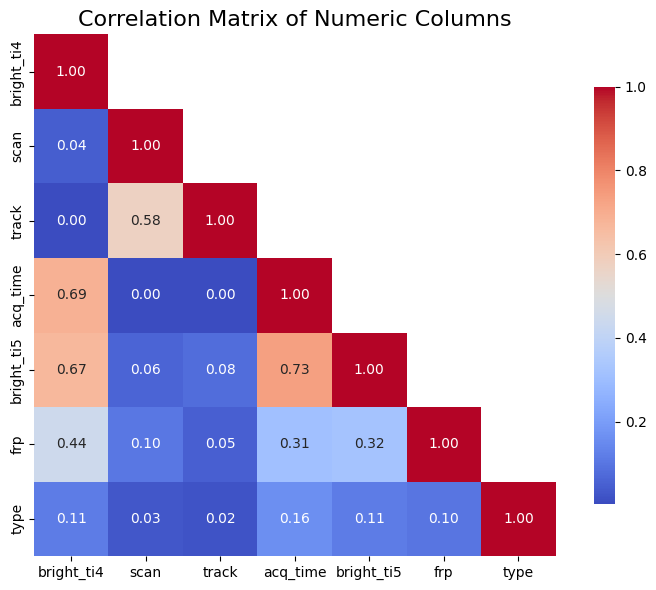

In [ ]:

numeric_cols = numeric_cols.loc[:, numeric_cols.nunique() > 1]

# Correlation analysis
correlation_matrix = numeric_cols.corr().abs()

def plot_correlation_matrix(correlation_matrix):
    mask = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": .8})
    plt.title("Correlation Matrix of Numeric Columns", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_correlation_matrix(correlation_matrix)

In [ ]:
COLONNES_ESSENTIELLES = ['longitude', 'latitude', 'type'] 
dataset = dataset[COLONNES_ESSENTIELLES].copy()
dataset.drop(dataset[dataset['type'] != 0].index, inplace=True)
print(dataset.shape)




(14216, 3)


In [68]:

grid_resolution = 0.01

# Get bounds of your data
lat_min, lat_max = dataset['latitude'].min(), dataset['latitude'].max()
lon_min, lon_max = dataset['longitude'].min(), dataset['longitude'].max()

# Add buffer to ensure complete coverage
buffer = grid_resolution
lat_min -= buffer
lat_max += buffer
lon_min -= buffer
lon_max += buffer

# Create grid
lats = np.arange(lat_min, lat_max, grid_resolution)
lons = np.arange(lon_min, lon_max, grid_resolution)
lons, lats = np.meshgrid(lons, lats)
lons = lons.ravel()
lats = lats.ravel()

# Load country boundaries (Algeria and Tunisia from shapefile)
shp_path = "../local_dataset/raw/world/ne_110m_admin_0_countries.shp"
world = gpd.read_file(shp_path)
countries = world[world["ADMIN"].isin(["Algeria", "Tunisia"])]
countries = countries.to_crs(epsg=4326)

# Convert grid to GeoDataFrame
grid = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(x=lons, y=lats),
    crs="EPSG:4326"
)

# Filter grid points that fall within Algeria and Tunisia boundaries
# grid_gdf = gpd.sjoin(grid_gdf, countries[['geometry']], how='inner', predicate='within')
grid = gpd.clip(grid, countries)
# grid_gdf = grid_gdf.drop(columns=['index_right'])
print(f"Total grid cells (within Algeria & Tunisia): {len(grid)}")
grid = pd.DataFrame({
    "fire": 0,
    "lon": grid.geometry.x,
    "lat": grid.geometry.y
})


#  Knn for faster search 
fire_coords = dataset[['latitude', 'longitude']].values
tree = cKDTree(fire_coords)

# Find which grid cells contain fire points
tolerance = grid_resolution / 2
distances, indices = tree.query(grid[["lat", "lon"]].values, 
                                distance_upper_bound=tolerance)
print("Finished computing distances.")
print(distances)

# Create fire/no-fire label (1 = fire, 0 = no fire)
grid.loc[distances < tolerance, 'fire'] = 1  # mark cells with fire points

print(f"Total grid cells (within Algeria & Tunisia): {len(grid)}")
print(f"Fire cells: {(grid['fire'] == 1).sum()}")
print(f"No-fire cells: {(grid['fire'] == 0).sum()}")
print(f"\nGrid statistics:")
print(grid['fire'].value_counts())

Total grid cells (within Algeria & Tunisia): 2261028
Finished computing distances.
[inf inf inf ... inf inf inf]
Total grid cells (within Algeria & Tunisia): 2261028
Fire cells: 2985
No-fire cells: 2258043

Grid statistics:
fire
0    2258043
1       2985
Name: count, dtype: int64


In [70]:
grid_fire = grid[grid['fire'] == 1]
grid_no_fire = grid[grid['fire'] == 0]
grid_balanced = pd.concat([grid_fire] + [grid_no_fire.sample(n=len(grid_fire) * 5, random_state=42)]).reset_index(drop=True)
print(f"Balanced grid cells: {len(grid_balanced)}")
print(f"Fire cells: {(grid_balanced['fire'] == 1).sum()}")
print(f"No-fire cells: {(grid_balanced['fire'] == 0).sum()}")

Balanced grid cells: 17910
Fire cells: 2985
No-fire cells: 14925


Original number of points: 17910
Sampled number of points: 17910


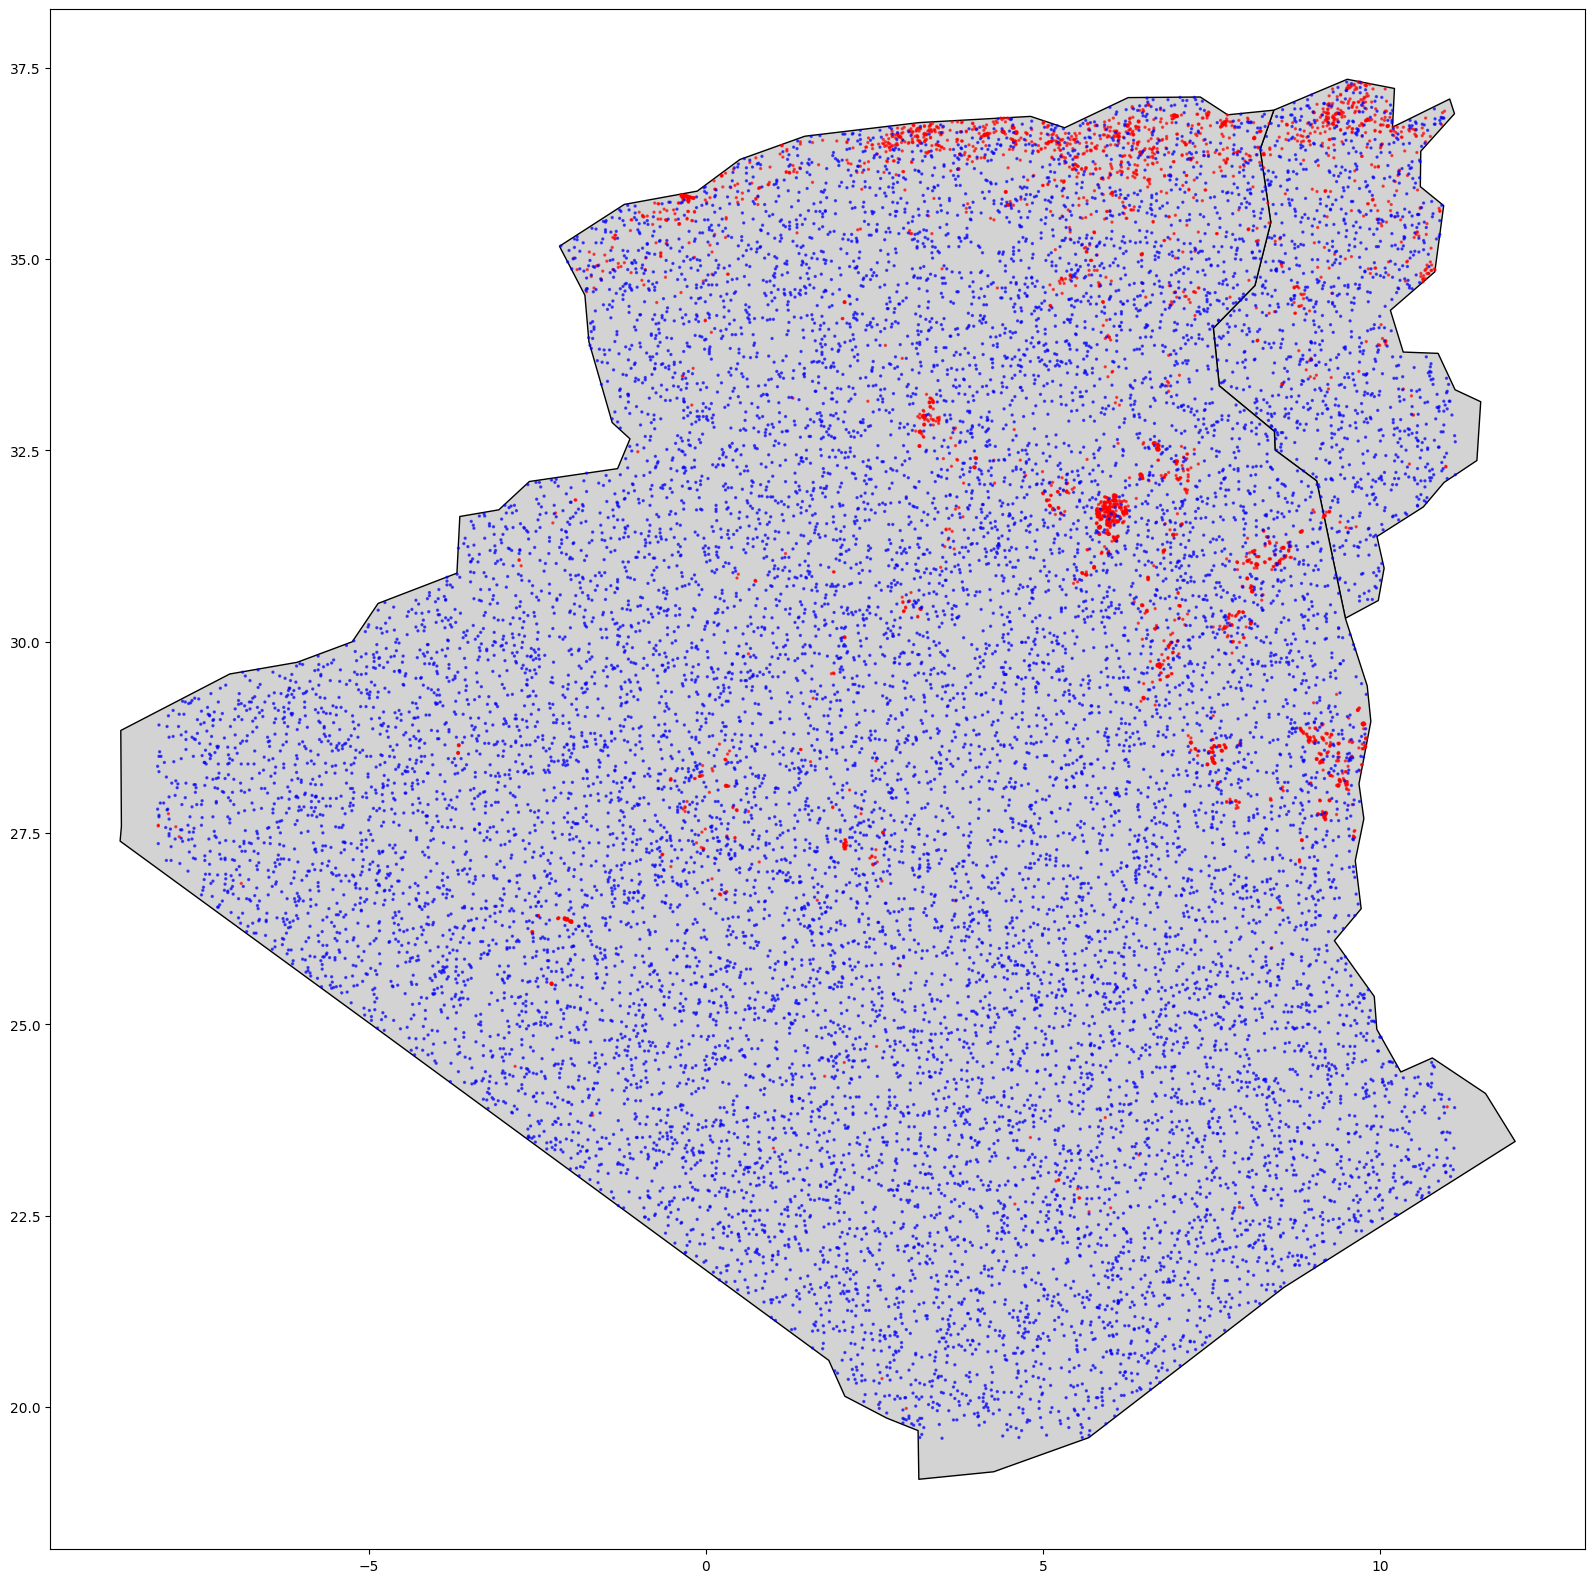

In [73]:

threshold = 0.01 # degrees 
# Create binned coordinates (temporary) 
lon_bin = (grid_balanced["lon"] / threshold).round(0) 
lat_bin = (grid_balanced["lat"] / threshold).round(0) 
# Group by bins and take the first point in each bin 
# sampled_grid = grid_balanced.groupby([lon_bin, lat_bin], sort=False).first().reset_index(drop=True)
sampled_grid = grid_balanced 
print("Original number of points:", len(grid_balanced)) 
print("Sampled number of points:", len(sampled_grid)) # plot the map and then overlay the points 
colors = sampled_grid['fire'].map({0: 'blue', 1: 'red'})
fig, ax = plt.subplots(figsize=(20, 20))
countries.plot(ax=ax, color='lightgrey', edgecolor='black')

# Overlay points with fixed marker size in points²
ax.scatter(
    sampled_grid["lon"],
    sampled_grid["lat"],
    c=colors,
    s=2,  # marker size in points²
    alpha=0.6
)

plt.show()

# Export cleaned dataset

In [74]:

grid_balanced.to_parquet(r"../local_dataset/dataset/fire_full.parquet", engine='fastparquet')
